## snipgenie testing notebook

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* [Woodchester Park eLife paper](https://elifesciences.org/articles/45833)
* [An African origin for Mycobacterium bovis](https://academic.oup.com/emph/article/2020/1/49/5719036)
* http://www.htslib.org/doc/bcftools.html
* https://mtbgenomicsworkshop.readthedocs.io/
* [BCFtools cheat sheet](https://gist.github.com/elowy01/93922762e131d7abd3c7e8e166a74a0b)
* https://biopython.org/wiki/Category:Cookbook
* https://pyvcf.readthedocs.io/en/v0.4.6/INTRO.html
* https://gatkforums.broadinstitute.org/gatk/discussion/1268/what-is-a-vcf-and-how-should-i-interpret-it

In [1]:
import sys,os,shutil,subprocess
import random
import glob, time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import seaborn as sns
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
sys.path.append('snipgenie')
from snipgenie import tools, aligners, app, trees, plotting
#from matplotlib_venn import venn2

## Mbovis samples from SRA

In [ ]:
sra = pd.read_csv('../sra_mbovis_runtable.csv')

## Get master table with Loiseau et al. meta data¶

In [3]:
df = pd.read_excel('../Loiseau_TableS1.xlsx')
master = pd.merge(df,sra,left_on='BIOSAMPLE',right_on='BioSample',how='inner')
master.to_csv('../mbovis_sra_master.csv',index=False)
cols = ['Run','CLONAL_COMPLEX','COUNTRY_ISOLATION','LibraryLayout','Host','ReleaseDate','Bytes','Bases','GENOME_COVERAGE']
#master.columns
#master.geo_loc_name_country.value_counts()

## Representative samples of lineages

In [4]:
sub=master[(master.LibraryLayout=='PAIRED') & (master.COUNTRY_ISOLATION.notnull()) & (master.CLONAL_COMPLEX=='Eu2')]
#print (sub[cols])
#sub[cols].to_csv('../temp.csv')
accessions=['SRR1792002','SRR5216872','SRR5486071','ERR841808','ERR125601',
            'SRR8063654','SRR8063665','SRR8065079','SRR1791768','SRR1791960','ERR2815558']
testset = master[master.Run.isin(accessions)]
print (testset[cols])

             Run CLONAL_COMPLEX COUNTRY_ISOLATION LibraryLayout        Host           ReleaseDate        Bytes        Bases  GENOME_COVERAGE
36     ERR841808            Eu1                UK        PAIRED         Cow  2015-12-02T00:00:00Z  130651179.0  196040478.0            39.78
245   SRR5216872            Eu1       New Zealand        PAIRED      BOVINE  2017-01-31T00:00:00Z  194523112.0  295803584.0            41.39
464   SRR5486071       Unknown2          Ethiopia        PAIRED  Bos taurus  2017-04-28T00:00:00Z  251875435.0  445066100.0            50.71
677    ERR125601            Eu1           Ireland        PAIRED         NaN  2012-10-01T00:00:00Z  277182504.0  346340680.0            68.83
765   ERR2815558            Af1               NaN        PAIRED         NaN  2018-09-29T00:00:00Z  162711425.0  367702705.0            67.64
886   SRR1791768            Eu2            Canada        PAIRED      Cattle  2015-03-11T00:00:00Z  340596851.0  450406275.0            37.69
1076  SRR1791

In [ ]:
# fetch from SRA
def fetch_sra_reads(df,path):
    """download a subset of reads """
    
    for i,r in df.iterrows():
        files = glob.glob(os.path.join(path,r.Run+'*'))        
        if len(files)==0:
            cmd = 'fastq-dump --split-files {n} --outdir {o}'.format(n=r.Run,o=path)
            print (cmd)
            subprocess.check_output(cmd,shell=True)

fetch_sra_reads(testset,path='/storage/btbgenie/mbovis_sra')

## Examine FASTQ file quality and define trimming parameters

In [ ]:
reload(tools)

df = tools.fastq_to_dataframe(testfile)
df.length.hist()

In [ ]:
def trim_reads_default(filename, outfile, right_quality=30):
    """Trim adapters"""
        
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    c=0
    out = gzopen(outfile, "wt")
    for record in fastq_parser:
        score = record.letter_annotations["phred_quality"]         
        for i in range(len(score)-1,0,-1):
            if score[i] >= right_quality:
                break
        #trimmed.append(record[:i])
        #print (record[:i])        
        #c+=1
        #if c>100:
        #    break    
        SeqIO.write(record[:i],out,'fastq')
    return

testfile = 'mbovis_sra/SRR1791711_1.fastq.gz'
st=time.time()
trim_reads_default(testfile,'trimmed.fastq.gz')
print (time.time()-st)
df = tools.fastq_to_dataframe('trimmed.fastq.gz')
df.length.hist()

## multiprocess trimming

In [ ]:
def split_fastq(filename, chunks=4):
    """Split fastq file"""
    
    names=[]
    tmp = '/tmp'
    tmpfiles = []
    record_iter = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    length = 
    for i, batch in enumerate(tools.batch_iterator(record_iter, chunksize)):
        tempfile = "group_%i.fastq" % (i + 1)
        tmpfiles.append(tempfile)
        names.append(tempfile)
        with open(tempfile, "w") as handle:
            count = SeqIO.write(batch, handle, "fastq")
        print("Wrote %i records to %s" % (count, tempfile))
    return names

split_fastq(testfile)

In [ ]:
tools.plot_fastq_qualities(testfile,limit=100000)
plt.savefig('fastq_quals.png',dpi=100)
tools.plot_fastq_gc_content(testfile, limit=50000)
plt.savefig('gc.png',dpi=100)

## remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

## run new method

## filtering

```
FORMAT/AD   .. Allelic depth (Number=R,Type=Integer)
FORMAT/ADF  .. Allelic depths on the forward strand (Number=R,Type=Integer)
FORMAT/ADR  .. Allelic depths on the reverse strand (Number=R,Type=Integer)
FORMAT/DP   .. Number of high-quality bases (Number=1,Type=Integer)
FORMAT/SP   .. Phred-scaled strand bias P-value (Number=1,Type=Integer)
FORMAT/SCR  .. Number of soft-clipped reads (Number=1,Type=Integer)

INFO/AD     .. Total allelic depth (Number=R,Type=Integer)
INFO/ADF    .. Total allelic depths on the forward strand (Number=R,Type=Integer)
INFO/ADR    .. Total allelic depths on the reverse strand (Number=R,Type=Integer)
INFO/SCR    .. Number of soft-clipped reads (Number=1,Type=Integer)

FORMAT/DV   .. Deprecated in favor of FORMAT/AD; Number of high-quality non-reference bases, (Number=1,Type=Integer)
FORMAT/DP4  .. Deprecated in favor of FORMAT/ADF and FORMAT/ADR; Number of high-quality ref-forward, ref-reverse,
               alt-forward and alt-reverse bases (Number=4,Type=Integer)
FORMAT/DPR  .. Deprecated in favor of FORMAT/AD; Number of high-quality bases for each observed allele (Number=R,Type=Integer)
INFO/DPR    .. Deprecated in favor of INFO/AD; Number of high-quality bases for each observed allele (Number=R,Type=Integer)
```

Joe filters: DP - 30, DP4 - 4, MQ - 35, SUP - 0.95 and COV - 0.05. GQ and FQ = 0

## Other options

```
biallelic: -m2 -M2
uninformative sites, where the minor allele is present in at least one individual: --min-ac 1:minor
```

In [ ]:
import vcf
vcf_reader = vcf.Reader(open('mapped/filtered.vcf.gz', 'rb')) 
for record in vcf_reader:
    print (record)
    for sample in record.samples:
        print (sample)

In [ ]:
cmd = 'bcftools filter -e "QUAL<=40 && DP>=30 && DP4>=4 && MQ>=35" -o filtered.vcf.gz -O z mapped/calls.vcf'
print (cmd)
tmp = subprocess.check_output(cmd,shell=True)
v = vcf_to_dataframe('filtered.vcf.gz')
v.var_type.value_counts()

## test filters

* https://samtools.github.io/bcftools/howtos/filtering.html

In [ ]:
vdf = vcf_to_dataframe('test.vcf')
vdf

In [ ]:
print (vdf[vdf.end==2839071])

In [ ]:
vdf.groupby('end').agg({'DP':sum}).sort_values(by='DP')

In [ ]:
u = vdf.drop_duplicates(['sample','mut']).set_index(['mut','sample'])['ALT'].unstack('sample')
u[:30]

In [ ]:
cmd = 'bcftools filter -e "QUAL<40 & FMT/DP<30" -o test.vcf.gz -O z test.vcf'
subprocess.check_output(cmd,shell=True)
fdf = vcf_to_dataframe('test.vcf.gz')
fdf[fdf.end==2839071]

## Make fasta alignment from filtered VCF sites with multiple samples

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

"The allele frequencies at each position in the aligned (against reference) sequence from each isolate were examined. For a haploid organism these frequencies are expected to be either 0 or 1, with some random variation expected from sequencing errors (Sobkowiak et al., 2018). A heterozygous site was defined as one where the allele frequencies were >0.05 and <0.95. Four cattle-derived sequences that had more than 150 heterozygous sites, and allele frequencies that were clustered and non-random (data not shown), were removed. In addition, 26 badger-derived and 16 cattle-derived M. bovis sequences were removed because of suspected errors in the metadata (Appendix 1: Investigating isolate metadata discrepancies).

For the sequences from the remaining isolates (204 badger- and 169 cattle-derived isolates), alleles were called at each variant position if they had mapping quality ≥30, high-quality base depth ≥4 (applied to reverse and forward reads separately), read depth ≥30, and allele support ≥0.95. For any site that failed these criteria, if the allele called had been observed in a different isolate that had passed, a second round of filtering was conducted using a high-quality base depth of 5 (total across forward and reverse reads) and the same allele support. As recombination is thought to be extremely rare for mycobacteria (Namouchi et al., 2012), variants in close proximity could indicate a region that is difficult to sequence or under high selection. To avoid calling variants in these regions, variant positions within 10 bp of one another were removed. Following filtering, sequences from 11 badger and 10 cattle isolates that had insufficient coverage (<95%) of the variant positions were removed. Once the alignment was generated, sites with a consistency index less than 1, generally considered homoplasies (Farris, 1989), were removed (n = 4, of 14,991 sites) using HomoplasyFinder (v0.0.0.9; Crispell et al., 2019; RRID: SCR_017300). All the scripts necessary for the processing of the WGS data are freely available online."

In [42]:
def core_alignment_from_vcf(vcf_file, callback=None, uninformative=False, missing=False, omit=None):
    """
    Get core SNP site calls as sequences from a multi sample vcf file.
    Args:
        vcf_file: multi-sample vcf (e.g. produced by app.variant_calling)
        uninformative: whether to include uninformative sites
        missing: whether to include sites with one or more missing samples (ie. no coverage)
        omit: list of samples to exclude if required
    """

    import vcf
    from collections import defaultdict
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    #print (vcf_reader.samples)
    def default():
        return []
    result = defaultdict(default)
    sites = []
    result['ref'] = []
    missing_sites = []
    uninf_sites = []
    for record in vcf_reader:
        S = {sample.sample: sample.gt_bases for sample in record.samples}
        if omit != None:
            for o in omit:
                del S[o]
        #if any missing samples at the site we don't add
        if None in S.values():
            missing_sites.append(record.POS)            
            if missing == False:                
                continue
                
        #ignore uninformative sites
        if uninformative == False:
            u = set(S.values())
            if len(u) == 1:
                uninf_sites.append(record.POS)
                continue
        result['ref'].append(record.REF)
        #get bases over all samples
        for name in S:
            val = S[name]
            if val == None:
                val = 'N'
            result[name].append(val)
        sites.append(record.POS)
        
    sites = list(set(sites))
    print ('used %s sites for core snps' %len(sites))
    print ('%s sites with at least one missing sample' %len(missing_sites))
    if uninformative == False:
        print ('%s uninformative sites' %len(uninf_sites))
    if len(sites)==0:
        print ('no sites found may mean:\n'
         '- one sample is too different\n'
         '- few reads aligned due to poor coverage')
    recs = []
    for sample in result:
        seq = ''.join(result[sample])
        seqrec = SeqRecord(Seq(seq),id=sample)
        recs.append(seqrec)
        #print (len(seqrec))

    smat = pd.DataFrame(result)    
    smat.index = sites
    smat.index.rename('pos', inplace=True)
    smat = smat.sort_index()
    return recs, smat

seqrecs, smat = core_alignment_from_vcf('/storage/btbgenie/wicklow_results/snps.vcf.gz')
seqrecs, smat = core_alignment_from_vcf('/storage/btbgenie/wicklow_results/snps.vcf.gz', missing=True)


used 165 sites for core snps
9 sites with at least one missing sample
273 uninformative sites
used 174 sites for core snps
9 sites with at least one missing sample
273 uninformative sites


## filters

In [145]:
def site_proximity_filter(vcf_file, dist=10, overwrite=False, outdir=None):
    """Remove any pairs of sites within dist of each other"""

    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    sites = [record.POS for record in vcf_reader]
    #print (sites)
    found = []
    for i in range(len(sites)-1):
        if sites[i+1] - sites[i] <= dist:
            #print (sites[i], sites[i+1],'close')
            found.extend([sites[i], sites[i+1]])
    #print (found)
    new = sorted(list(set(sites) - set(found)))
    print ('proximity filter found %s/%s sites' %(len(set(found)),len(sites)))
    if outdir == None:
        outdir = tempfile.gettempdir()
    if overwrite == True:
        out = os.path.join(outdir,'temp.vcf')
        vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
        vcf_writer = vcf.Writer(open(out, 'w'), vcf_reader)
        for record in vcf_reader:
            if record.POS in new:
                #print (record)
                vcf_writer.write_record(record)
        vcf_writer.close()
        #overwrite input vcf
        bcftoolscmd = tools.get_cmd('bcftools')
        cmd = 'bcftools view {o} -O z -o {gz}'.format(o=out,gz=vcf_file)
        tmp = subprocess.check_output(cmd,shell=True)
    return new

old = site_proximity_filter('/storage/btbgenie/sim_results/snps.vcf.gz')

proximity filter found 11/629 sites


In [133]:
df = tools.vcf_to_dataframe('/storage/btbgenie/sim_results/snps.vcf.gz') 
print (df[:4])
p=pd.pivot_table(df,index='pos',columns='sample',values='mut',aggfunc='size')
#p[p.isnull().sum(1)>0]

       sample REF ALT      mut   DP       ADF      ADR        AD       chrom var_type sub_type   pos   start     end   QUAL
0    13-11594   A   G  1057A>G  170  [0, 125]  [0, 45]  [0, 170]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0
1   14-MBovis   A   G  1057A>G  188  [0, 158]  [0, 30]  [0, 188]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0
2    15-11643   A   G  1057A>G  165  [0, 158]   [0, 7]  [0, 165]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0
3  161-MBovis   A   G  1057A>G  136  [0, 135]   [0, 1]  [0, 136]  LT708304.1      snp       ts  1057  1056.0  1057.0  999.0


In [112]:
fn = [2672966,2916881,3499480,3499469,3499476,2672970,2444846]

In [142]:
diff = list (set(new) - set(old))
sub=df[df.pos.isin(diff)]
p=pd.pivot_table(sub,index='pos',columns='sample',values='mut',aggfunc='first')
#import seaborn as sns
#sns.heatmap(p)
p.to_csv('proximity_changed.csv')

## mask locations for mbovis

In [ ]:
#make mask bed file for mbovis
g=tools.genbank_to_dataframe('../snipgenie/data/Mbovis_AF212297.gb')
g['gene'] = g.gene.fillna('')
g=g[(g.gene.str.contains('PE_PGRS') | g.gene.str.contains('PPE')) & (g.feat_type=='CDS') | (g.feat_type=='repeat_region')]
for i,r in g.iterrows():  
    print ('LT708304.1','\t', r.start, '\t', r.end, r.gene, r.locus_tag)

## mask for MTB

In [ ]:
#make mask bed file for mbovis
g=tools.genbank_to_dataframe('../snipgenie/data/MTB-H37Rv.gb')
g['gene'] = g.gene.fillna('')
g=g[(g.gene.str.contains('PE_PGRS') | g.gene.str.contains('PPE')) & (g.feat_type=='CDS') | (g.feat_type=='repeat_region')]
for i,r in g.iterrows():  
    print ('NC_000962.3','\t', r.start, '\t', r.end)#, r.gene, r.locus_tag)

In [210]:
def generic_multiprocess(inputs):
    #split sites into chunks and run in parallel for long jobs
    
    import multiprocessing as mp
    blocks = np.array_split(np.array(inputs),threads)
    result=[]
    funclist = []
    pool = mp.Pool(threads)
    for subset in blocks:            
        f = pool.apply_async(worker_func, [subset])      
        funclist.append(f)            
    try:
        for f in funclist:
            out = f.get(timeout=None)               
            if len(out)>0:
                result.append(out)
    except KeyboardInterrupt:
        print ('process interrupted')
        pool.terminate()
        sys.exit(0)

    pool.close()
    pool.join()    
    return result

### Phylogeny from MSA

In [ ]:
def create_tree(filename, labelmap=None):
    """Draw a tree """
    
    from ete3 import Tree, NodeStyle, TreeStyle
    t = Tree(filename)
    t.set_outgroup('ref')    
    if labelmap != None:
        trees.set_tiplabels(t,labelmap)
    trees.format_nodes(t)
    ts = TreeStyle()
    ts.scale=1000
    t.render("%%inline", tree_style=ts)
    t.render("tree.png", tree_style=ts)
    return t

sra['filename'] = sra.Run.apply(lambda x: 'mapped/'+x+'.bam')
print (sra[:3])
labelmap = dict(zip(sra.filename,sra.geo_loc_name_country))
#print (labelmap)
t = create_tree('RAxML_bipartitions.variants', labelmap)
t.render("%%inline")

In [ ]:
from Bio import Phylo
tree=Phylo.read('RAxML_bestTree.variants','newick')
Phylo.draw(tree)

## csq gff format

In [2]:
tools.gff_bcftools_format('../snipgenie/data/Mbovis_AF212297.gb', '../Mbovis_csq_new.gff')

/home/farrell/.local/lib/python3.10/site-packages/Bio/SeqFeature.py:257: BiopythonDeprecationWarning: Using the strand argument is deprecated, and will be removed in a future release. Please set it via the location object instead.
  warnings.warn(


In [ ]:
gff=tools.gff_to_features('../pathogenie/data/Mbovis_AF212297.gff')
g=tools.features_to_dataframe(gff)
tools.features_summary(g)

In [ ]:
reload(plotting)
f,ax=plt.subplots(1,1,figsize=(12,3))
st=time.time()
plotting.plot_bam_alignment('../test_results/mapped/3_S57_L001.bam', 'LT708304.1', 2000, 3000, yend=100, rect_height=3, ax=ax)
print (time.time()-st)

In [ ]:
def plot_features(rec, ax, rows=3, xstart=0, xend=30000):
    
    h=1
    df = tools.records_to_dataframe([rec])    
    df = df[(df.feat_type!='region') & (df['feat_type']!='source')]
    df = df[(df.start>xstart) & (df.end<xend)]
    df['length'] = df.end-df.start
    y = list(range(1,rows)) * len(df)
    df['y'] = y[:len(df)]
    df['color'] = 'blue'
    df = df.fillna('')
    #print (df)  
    
    from matplotlib.collections import PatchCollection
    import matplotlib.patches as mpatches

    patches=[]
    for i,r in df.iterrows():        
        #rect = plt.Rectangle((r.start, r.y), r.length, h/2,
        #                        alpha=.5, linewidth=.5,
        #                        edgecolor='black', facecolor=r.color)
        if r.strand == 1:
            x = r.start
            dx = r.length
        else:
            x = r.end
            dx = -r.length
        arrow = mpatches.Arrow(x, r.y, dx, 0, alpha=.7, width=.3, 
                               edgecolor='black')
        txt = ax.text(r.start, r.y-h/2, r.gene, size=16)
        patches.append(arrow)  
        
    ax.add_collection(PatchCollection(patches, match_original=True))  
    ax.set_xlim(xstart, xend)
    ax.set_ylim(.4,rows-.5)
    plt.yticks([])
    plt.tight_layout()

    def onclick(event):
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
              ('double' if event.dblclick else 'single', event.button,
               event.x, event.y, event.xdata, event.ydata))
        ax.text(event.x, event.y, 'HI!')
        ax.figure.canvas.draw()
    #cid = ax.figure.canvas.mpl_connect('button_press_event', onclick)
    return

reload(tools)
recs = tools.gff_to_records(app.mbovis_gff)
rec=recs[0]
f,ax=plt.subplots(1,1,figsize=(15,1.5))
plot_features(rec, ax=ax, xstart=26000,xend=35000)

## replace pysam

In [ ]:
def get_chrom(bam_file):
    """Get first sequence name in a bam file"""

    import pysam
    samfile = pysam.AlignmentFile(bam_file, "r")
    iter=samfile.fetch(start=0,end=10)
    for read in iter:
        if read.reference_name:
            return read.reference_name
        
get_chrom('mapped/3_S57_L001.bam')

In [4]:
import bamnostic as bs
bam = bs.AlignmentFile('mapped/3_S57_L001.bam', 'rb')

In [6]:
chrom=bam.header['SQ'][0]['SN']
chrom

'LT708304.1'

In [ ]:
for i, read in enumerate(bam.fetch(chrom, 1, 10)):
    print(read)

In [5]:
reload(tools)

def check_unmapped(fastafile):
    """Check possible source of unmapped reads"""
    
    recs=list(SeqIO.parse(fastafile,'fasta'))
    recs = recs[:900]
    SeqIO.write(recs,'temp.fa','fasta')
    tools.make_blast_database('contaminants.fa')
    bl = tools.blast_fasta('contaminants.fa', 'temp.fa',threads=8,show_cmd=True)    
    print (bl.stitle.value_counts())
    return bl

bl=check_unmapped('/storage/btbgenie/dup_results/unmapped/TB19-002014.bam.fasta')

blastn -out temp_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query temp.fa -db contaminants.fa -evalue 0.001 -max_target_seqs 50 -num_threads 8 -task blastn
LT708304.1 Mycobacterium bovis AF2122/97 genome assembly, chromosome: Mycobacterium_bovis_AF2122/97    932
NZ_CP021380.2 Pseudomonas aeruginosa strain CCBH4851 chromosome, complete genome                       240
Name: stitle, dtype: int64


In [ ]:
bl.qseq.value_counts()

## find all multimapping regions in bam file

In [63]:
bf = '/storage/btbgenie/dup_results/mapped/TB19-003437.bam'
out = 'multimapped.bam'
threads=4
cmd = 'samtools view -@ {t} -b -f 256 -F 4 -h  {b} > {o}'.format(b=bf,o=out,t=threads)
subprocess.check_output(cmd,shell=True)


b''

In [64]:
import bamnostic as bs

In [ ]:
def get_multimapped():
    bam = bs.AlignmentFile('/storage/btbgenie/dup_results/mapped/TB19-003437.bam', 'rb')
    i=0
    rc=[]

    for read in bam:
        if i > 1000000:
            break
        #if read.mapq == 0:
        rc.append(read.pos)
        i+=1
    
get_multimapped()

In [78]:
%%time 
get_multimapped()

CPU times: user 1min 50s, sys: 47.8 ms, total: 1min 50s
Wall time: 1min 50s


In [79]:
x=pd.Series(rc)
x.value_counts()

608012     13
1342643    13
892029     12
1170985    11
608386     11
           ..
1343378     1
104339      1
104343      1
608153      1
401408      1
Length: 4109, dtype: int64

In [65]:
bam = bs.AlignmentFile('multimapped.bam', 'rb')
res=[]
for read in bam:
    res.append((read.pos,read.seq,read.mapq))
    

In [66]:
df=pd.DataFrame(res,columns=['pos','seq','qual'])

0          32
1306895    17
2767810     8
3080741     6
1306896     5
4317352     5
3351441     4
1306875     4
1306879     3
956926      3
Name: pos, dtype: int64

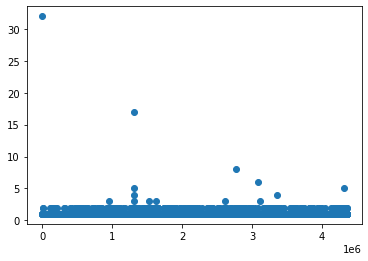

In [67]:
cts=df.pos.value_counts()
plt.scatter(x=cts.index,y=cts)
cts[:10]

## low quality samples checks

In [ ]:
args = {'threads':16, 'outdir': '/storage/btbgenie/monaghan/temp_results', 'labelsep':'_',  
        'input':['/storage/btbgenie/mbovis_ireland/Fastqs_06-10-22/'],
        'overwrite':False,
        'custom_filters': True,
        'mask': app.mbovis_mask,
        'unmapped': False,
        'buildtree': True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
import toytree, toyplot
treefile1 = '/storage/btbgenie/monaghan/temp_results/tree.newick'
tre = toytree.tree(treefile1)
canvas,t,r=tre.draw(layout='r',width=1200,height=900)

In [5]:
reload(tools)
seqrecs, smat = tools.core_alignment_from_vcf('/storage/btbgenie/monaghan/temp_results/snps.vcf.gz', missing=True)
SeqIO.write(seqrecs, 'core_test.fa','fasta')
treefile2 = trees.run_RAXML('core_test.fa', outpath='temp')

In [48]:
smat.to_csv('core_missing.txt', sep=' ')

In [ ]:
import toytree
tre = toytree.tree(treefile2)
canvas,t,r=tre.draw(layout='r',width=1200,height=900)

In [39]:
#by position
p=smat.T
p=p[p=='N'].count().sort_values(ascending=False)[:20]
exclude = p.index
p

pos
1928859    61
3688592    19
4017811    18
2461342    17
3075632    17
1599371    12
1599372    12
790175     11
4138897    10
2362656     7
4062199     7
3377055     6
2108702     6
2997998     6
3115153     5
902470      5
651354      5
1746821     5
4051374     4
3440364     4
dtype: int64

<AxesSubplot:>

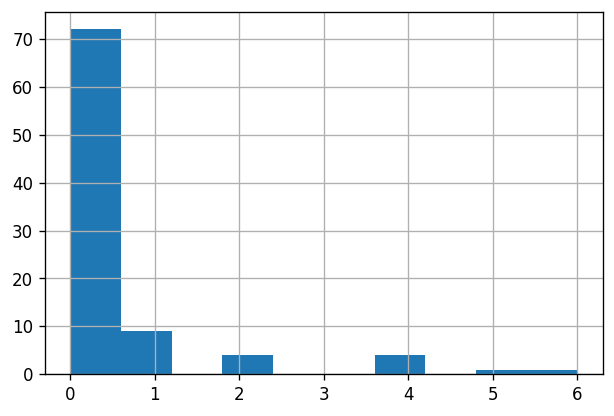

In [55]:
#exclude dodgy positions from matrix
dsmat = smat.loc[~smat.index.isin(exclude)]
#missing sites per sample
missing=dsmat[dsmat=='N'].count().sort_values()

print (missing)
#merge with coverage stats from run
samples=pd.read_csv('/storage/btbgenie/monaghan/temp_results/samples.csv')
x=samples.merge(missing.rename('missing'),right_index=True,left_on='sample')
sx=x[x.meandepth>5]
sx.missing.hist()

<AxesSubplot:xlabel='meandepth', ylabel='coverage'>

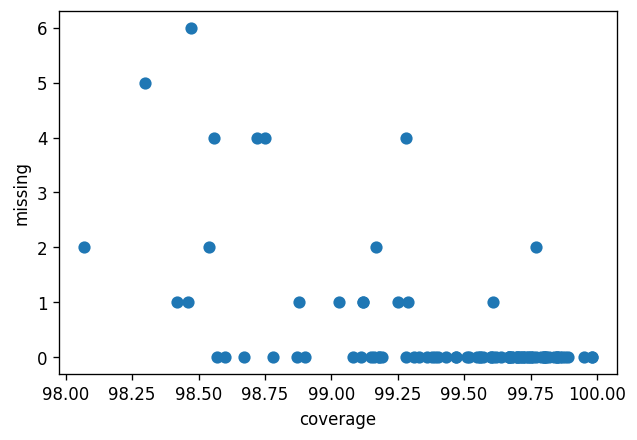

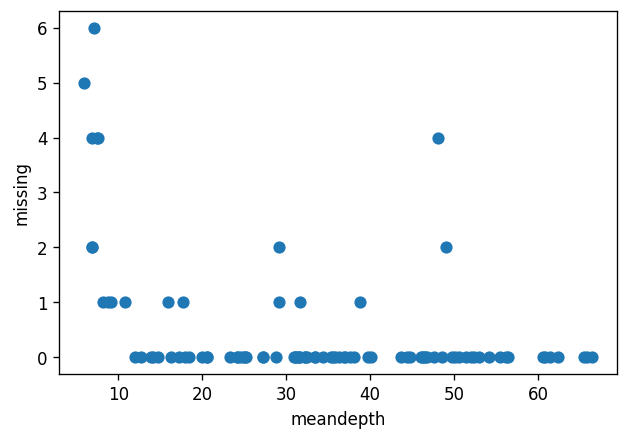

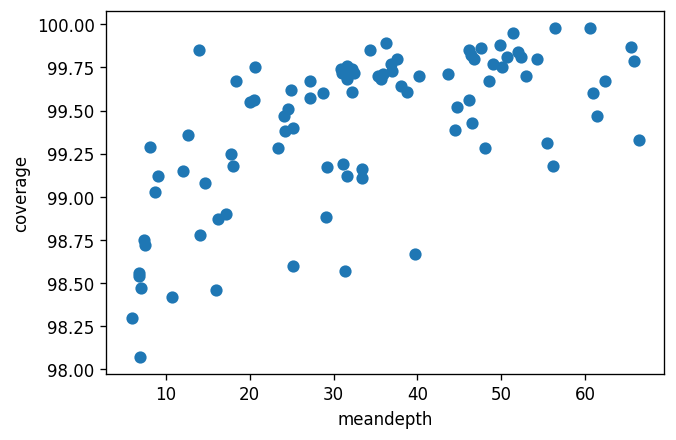

In [56]:
sx.plot('coverage','missing',kind='scatter',s=40)
sx.plot('meandepth','missing',kind='scatter',s=40)
sx.plot('meandepth','coverage',kind='scatter',s=40)

In [ ]:
x[['sample','missing','coverage','meandepth']].sort_values('missing',ascending=False)[:16]

In [23]:
#all monaghan
seqrecs, smat2 = tools.core_alignment_from_vcf('/storage/btbgenie/monaghan/monaghan_results/snps.vcf.gz', missing=True)
missingmon=smat2[smat2=='N'].count().sort_values()

found 3214 sites for core snps
113 sites with at least one missing sample
0 uninformative sites


In [ ]:
plt.rcParams['figure.dpi'] = 120
samples=pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/samples.csv')
monx=samples.merge(missingmon.rename('missing'),right_index=True,left_on='sample')
monsx=monx[monx.meandepth<100]
monsx.missing.hist()

In [ ]:
monsx.plot('coverage','missing',kind='scatter',s=40)
monsx.plot('meandepth','missing',kind='scatter',s=40)
monsx.plot('meandepth','coverage',kind='scatter',s=40)

In [ ]:
def distmatrix_to_tree(df, treefile=None):
    """Make nj tree from snp dist matrix"""
    
    from Bio import Phylo
    from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor

    #trim zeroes out 
    names = list(df.index)
    matrix = np.tril(df.values.tolist())
    M=[]
    for i in range(len(matrix)):
        M.append(list(matrix[i][:i+1]))
    #print (M)
    # Convert the distance matrix to a BioPython DistanceMatrix object
    dm = DistanceMatrix(names, M)    
    # Build the tree using the Neighbor-Joining algorithm
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm) 
    def remove_inner_labels(node):
        for child in node.clades:
            remove_inner_labels(child)
        if not node.is_terminal():
            node.name = None    
    remove_inner_labels(tree.root)    
    Phylo.draw(tree)
    if treefile != None:
        tree = Phylo.write(tree, treefile, 'newick')
    return tree
    
dm = pd.read_csv('/storage/btbgenie/wicklow_results/snpdist.csv', index_col=0)
dm = dm.iloc[:15,:15]
distmatrix_to_tree(dm)


## manifest file

In [ ]:
reload(app)
ref = app.sarscov2_genome
args = {'threads':12, 'outdir': 'test_results', 'labelsep':'.',
        #'input':'test_folder',        
        'manifest': 'testsamples.txt',
        'reference': ref,
        'overwrite':False,
        'filters':'',
        'custom_filters': False, 'get_stats':False}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
reload(app)
ref = app.sarscov2_genome
args = {'threads':12, 'outdir': '/home/farrell/espinoza/results', #'labelsep':'.',           
        'manifest': '/home/farrell/espinoza/reads_table.DENV2.csv',
        'reference': '/home/farrell/espinoza/DENV2.fa',
        'overwrite':False,
        'filters':'',
        'custom_filters': False}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [4]:
vcf_file = '/other/viktor_wgs/oct24_results/variant_calling/hsd_c1/snps.bcf'
vdf = tools.vcf_to_dataframe(vcf_file)

In [5]:
vdf

,sample,REF,ALT,mut,DP,ADF,ADR,AD,chrom,var_type,sub_type,pos,start,end,QUAL
0,/other/viktor_wgs/oct24_results/mapped/hsd_c1.bam,C,A,1190396C>A,1,"[0, 1]","[0, 0]","[0, 1]",LT708304.1,snp,tv,1190396,1190395,1190396,10.7923
1,/other/viktor_wgs/oct24_results/mapped/hsd_c1.bam,T,C,1343720T>C,1,"[0, 1]","[0, 0]","[0, 1]",LT708304.1,snp,ts,1343720,1343719,1343720,10.7923
2,/other/viktor_wgs/oct24_results/mapped/hsd_c1.bam,A,G,1475691A>G,483,"[0, 278]","[1, 201]","[1, 479]",LT708304.1,snp,ts,1475691,1475690,1475691,228.4260
